In [ ]:
# %% Cell 1: Import Libraries and Set Up the Environment
"""
Import required libraries, set random seeds for reproducibility,
and configure matplotlib for inline plotting.
We use PyTorch for modeling, NumPy for data generation, matplotlib for visualization,
and scikit-learn for dataset splitting and evaluation.
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set random seeds for reproducibility
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
random.seed(seed_val)

# Configure matplotlib
%matplotlib inline

print("Libraries imported. PyTorch version:", torch.__version__)

Libraries imported. PyTorch version: 2.5.1+cu124


In [ ]:
# %% Cell 2: Generate a Synthetic Dataset Relevant to Materials Science
"""
In this cell, we generate a synthetic dataset simulating the tensile strength of alloys.
Each sample represents an alloy with 8 features such as composition percentages and processing parameters.
The target (tensile strength) is computed using a nonlinear combination of the features plus some noise.
This dataset mimics real materials science data used in predicting mechanical properties.
"""
def generate_tensile_strength_data(n_samples=1000, n_features=8, noise_std=5.0):
    """
    Generate synthetic data for predicting tensile strength.

    Args:
        n_samples (int): Number of samples (alloy experiments).
        n_features (int): Number of features per sample.
        noise_std (float): Standard deviation of Gaussian noise.

    Returns:
        X (np.array): Features array of shape (n_samples, n_features).
        y (np.array): Target tensile strength values of shape (n_samples,).
    """
    # Generate random features between 0 and 100 (e.g., composition percentages, processing temperature, etc.)
    X = np.random.uniform(0, 100, size=(n_samples, n_features))

    # Define a nonlinear function to simulate tensile strength (in MPa)
    # For example, tensile strength might depend on a sine of the first feature,
    # logarithm of the second feature (shifted to avoid log(0)), quadratic terms, and interactions.
    y = (50 * np.sin(X[:, 0] / 20) +
         0.3 * np.log(X[:, 1] + 1) +
         0.05 * (X[:, 2] ** 2) -
         0.2 * np.sqrt(X[:, 3] + 1) +
         0.1 * X[:, 4] * X[:, 5] -
         0.05 * X[:, 6] +
         0.07 * X[:, 7] +
         20)  # base strength offset

    # Add Gaussian noise to simulate experimental variability
    y += np.random.normal(0, noise_std, size=y.shape)

    return X, y

# Generate dataset
X, y = generate_tensile_strength_data(n_samples=1000, n_features=8, noise_std=5.0)
print("Synthetic dataset generated:")
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Synthetic dataset generated:
Features shape: (1000, 8)
Target shape: (1000,)


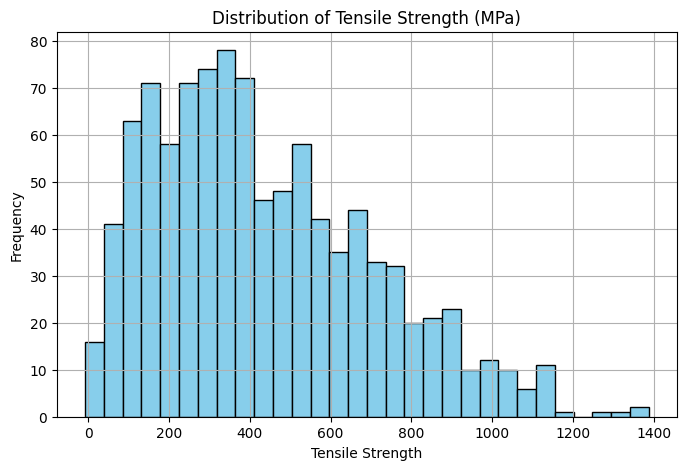

Train set size: 699
Validation set size: 151
Test set size: 150


In [ ]:
# %% Cell 3: Visualize the Dataset and Perform Train/Validation/Test Split
"""
Visualize a few features and the target distribution.
Then, split the dataset into training, validation, and testing sets.
We use an 70/15/15 split to mimic a real-world scenario.
"""
# Plot histogram of target tensile strength values
plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Tensile Strength (MPa)")
plt.xlabel("Tensile Strength")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Split the dataset into train (70%), validation (15%), and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=seed_val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=seed_val)
# Note: 0.1765 of 85% approximates 15% of the overall data
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

In [ ]:
# %% Cell 4: Create a PyTorch Dataset and DataLoaders for Regression
"""
Convert the NumPy arrays into PyTorch tensors and create a custom Dataset.
Then, wrap them into DataLoaders for batch processing.
We standardize features and targets to improve training stability.
"""
# Standardize the features (mean=0, std=1) using training set statistics
mean_X = X_train.mean(axis=0)
std_X = X_train.std(axis=0)
X_train_std = (X_train - mean_X) / std_X
X_val_std = (X_val - mean_X) / std_X
X_test_std = (X_test - mean_X) / std_X

# Standardize targets (optional, here we keep in original scale for interpretation)
# But for stability, we can also scale y if necessary.
# For demonstration, we leave y unchanged.

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape [n,1]
X_val_tensor = torch.tensor(X_val_std, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created:")
print("Train:", len(train_loader), "batches")
print("Validation:", len(val_loader), "batches")
print("Test:", len(test_loader), "batches")

DataLoaders created:
Train: 22 batches
Validation: 5 batches
Test: 5 batches


In [ ]:
# %% Cell 5: Define a Baseline Deep Neural Network Model (Fully Connected)
"""
Define a simple fully connected neural network (baseline model) for regression.
This network has two hidden layers with ReLU activations.
It serves as our starting point before applying adjustments.
"""
class BaselineNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, output_dim=1):
        super(BaselineNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train_tensor.shape[1]
model_baseline = BaselineNN(input_dim=input_dim)
print("Baseline model defined:")
print(model_baseline)

Baseline model defined:
BaselineNN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
# %% Cell 6: Define a Function to Train the Model (with Validation Monitoring)
"""
Define a training function that trains the model for a given number of epochs.
It records training and validation loss, and returns the loss history.
We also monitor the validation performance for potential early stopping.
"""
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cpu'):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Evaluate on validation set
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs_val, targets_val in val_loader:
                inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, targets_val)
                running_val_loss += loss_val.item() * inputs_val.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")

    return train_losses, val_losses

# Set training parameters and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=0.001)

# Train the baseline model
print("\nTraining baseline model...")
train_losses_baseline, val_losses_baseline = train_model(model_baseline, train_loader, val_loader, criterion, optimizer_baseline, num_epochs=100, device=device)



Training baseline model...
Epoch 10/100: Train Loss = 190577.1726, Val Loss = 181015.7908
Epoch 20/100: Train Loss = 10953.7720, Val Loss = 10527.5350
Epoch 30/100: Train Loss = 6291.3657, Val Loss = 6196.9541
Epoch 40/100: Train Loss = 5586.5320, Val Loss = 5623.8337
Epoch 50/100: Train Loss = 4861.1980, Val Loss = 5037.7770
Epoch 60/100: Train Loss = 4129.1862, Val Loss = 4398.3322
Epoch 70/100: Train Loss = 3468.6711, Val Loss = 3825.0621
Epoch 80/100: Train Loss = 2951.2555, Val Loss = 3340.3402
Epoch 90/100: Train Loss = 2620.1047, Val Loss = 3051.1090
Epoch 100/100: Train Loss = 2417.9050, Val Loss = 2887.2437


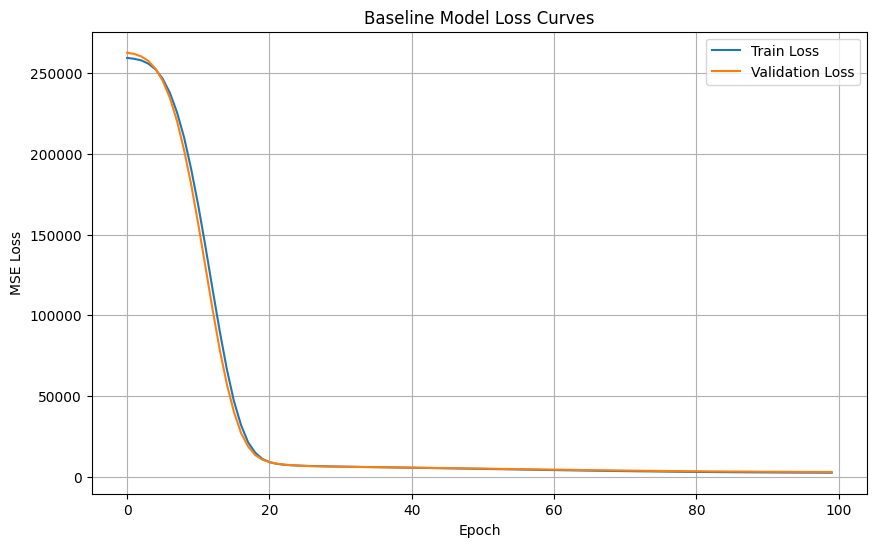

In [ ]:
# %% Cell 7: Plot Training and Validation Loss for Baseline Model
"""
Plot the training and validation loss curves of the baseline model.
This visualization helps us understand the model's learning dynamics and detect overfitting.
"""
plt.figure(figsize=(10, 6))
plt.plot(train_losses_baseline, label="Train Loss")
plt.plot(val_losses_baseline, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Baseline Model Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# %% Cell 8: Adjust the Model by Adding Dropout
"""
Introduce dropout layers into the network to reduce overfitting.
Here, we modify the baseline model by inserting dropout after the first hidden layer.
Dropout randomly sets a fraction of activations to zero during training.
"""
class DropoutNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, output_dim=1, dropout_prob=0.5):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_dropout = DropoutNN(input_dim=input_dim, dropout_prob=0.5)
print("Model with dropout defined:")
print(model_dropout)

# Train the dropout model
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=0.001)
print("\nTraining model with dropout...")
train_losses_dropout, val_losses_dropout = train_model(model_dropout, train_loader, val_loader, criterion, optimizer_dropout, num_epochs=100, device=device)


Model with dropout defined:
DropoutNN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Training model with dropout...
Epoch 10/100: Train Loss = 189738.5538, Val Loss = 181793.1493
Epoch 20/100: Train Loss = 15038.5400, Val Loss = 9803.2047
Epoch 30/100: Train Loss = 12499.1976, Val Loss = 6100.0788
Epoch 40/100: Train Loss = 11140.3806, Val Loss = 5916.6107
Epoch 50/100: Train Loss = 11146.0784, Val Loss = 5664.9769
Epoch 60/100: Train Loss = 10180.0699, Val Loss = 5328.9665
Epoch 70/100: Train Loss = 10993.5576, Val Loss = 4803.8057
Epoch 80/100: Train Loss = 8604.5771, Val Loss = 4535.9915
Epoch 90/100: Train Loss = 8981.1285, Val Loss = 4346.0831
Epoch 100/100: Train Loss = 8946.4382, Val Loss = 3953.0126


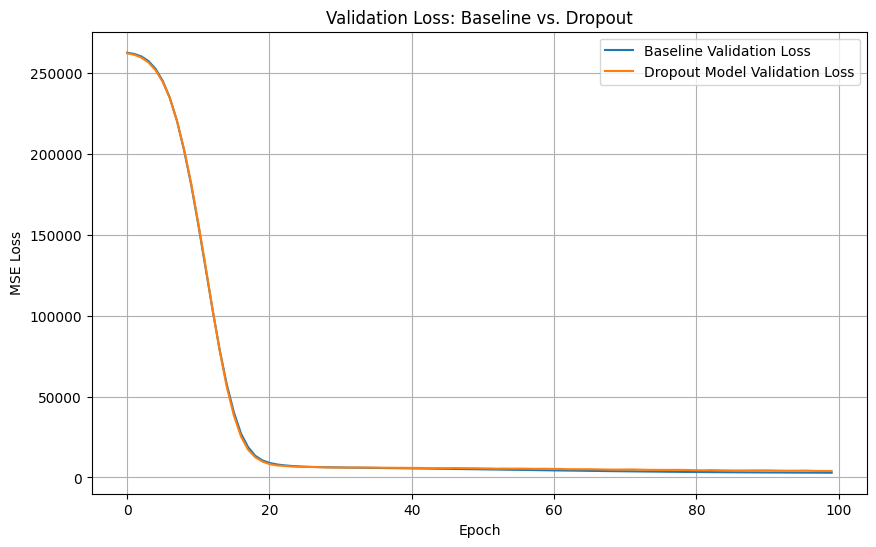

In [ ]:
# %% Cell 9: Plot Loss Curves: Baseline vs. Dropout Model
"""
Compare the training and validation loss curves of the baseline model and the dropout model.
This helps illustrate how dropout affects learning and generalization.
"""
plt.figure(figsize=(10, 6))
plt.plot(val_losses_baseline, label="Baseline Validation Loss")
plt.plot(val_losses_dropout, label="Dropout Model Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Validation Loss: Baseline vs. Dropout")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# %% Cell 10: Adjust the Model by Adding Batch Normalization
"""
Incorporate batch normalization into the network to stabilize and accelerate training.
We modify the baseline model to include batch normalization layers after the fully connected layers.
"""
class BatchNormNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, output_dim=1):
        super(BatchNormNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

model_bn = BatchNormNN(input_dim=input_dim)
print("Model with batch normalization defined:")
print(model_bn)

# Train the batch normalization model
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)
print("\nTraining model with batch normalization...")
train_losses_bn, val_losses_bn = train_model(model_bn, train_loader, val_loader, criterion, optimizer_bn, num_epochs=100, device=device)



Model with batch normalization defined:
BatchNormNN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Training model with batch normalization...
Epoch 10/100: Train Loss = 251284.4046, Val Loss = 253911.8086
Epoch 20/100: Train Loss = 234300.1335, Val Loss = 235822.4946
Epoch 30/100: Train Loss = 209037.0350, Val Loss = 209311.6031
Epoch 40/100: Train Loss = 179392.6428, Val Loss = 177333.8712
Epoch 50/100: Train Loss = 147724.7996, Val Loss = 146718.3041
Epoch 60/100: Train Loss = 116296.2911, Val Loss = 121315.1669
Epoch 70/100: Train Loss = 87976.9160, Val Loss = 84789.6973
Epoch 80/100: Train Loss = 62823.4393, Val Loss = 63286.5480
Epoch 90/100: Train Loss = 45676.1731, Val Lo

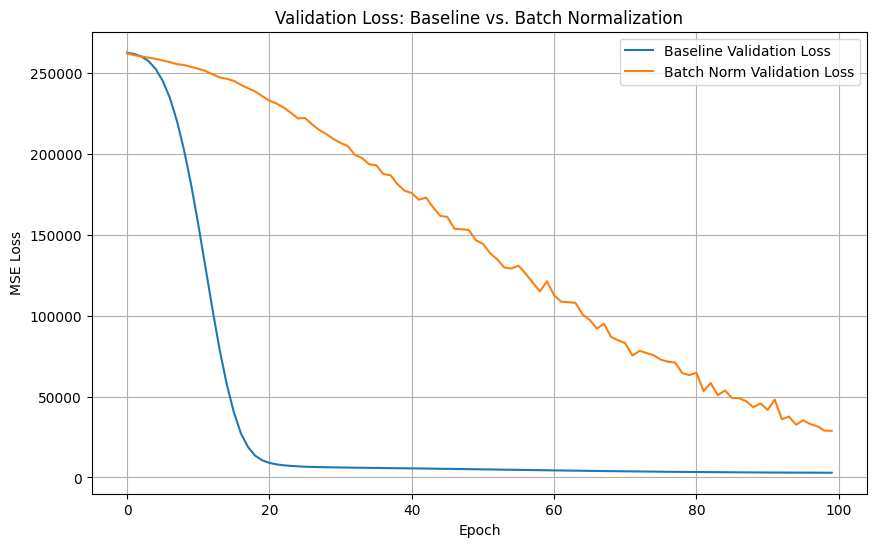

In [ ]:
# %% Cell 11: Plot Loss Curves: Baseline vs. Batch Normalization
"""
Plot the validation loss curves of the baseline and batch-normalized models.
This comparison shows the impact of normalization on convergence and performance.
"""
plt.figure(figsize=(10, 6))
plt.plot(val_losses_baseline, label="Baseline Validation Loss")
plt.plot(val_losses_bn, label="Batch Norm Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Validation Loss: Baseline vs. Batch Normalization")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# %% Cell 12: Build a Deeper Network by Increasing the Number of Layers
"""
Now we increase the network depth by adding more hidden layers.
A deeper network may capture more complex nonlinear relationships but is also prone to overfitting.
We build a deeper model with three hidden layers and use ReLU activations.
"""
class DeeperNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_prob=0.3):
        super(DeeperNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_deeper = DeeperNN(input_dim=input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_prob=0.3)
print("Deeper model defined:")
print(model_deeper)

# Train the deeper network
optimizer_deeper = optim.Adam(model_deeper.parameters(), lr=0.001)
print("\nTraining deeper model...")
train_losses_deeper, val_losses_deeper = train_model(model_deeper, train_loader, val_loader, criterion, optimizer_deeper, num_epochs=100, device=device)


Deeper model defined:
DeeperNN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Training deeper model...
Epoch 10/100: Train Loss = 11685.2258, Val Loss = 6939.4980
Epoch 20/100: Train Loss = 8423.6942, Val Loss = 4795.6431
Epoch 30/100: Train Loss = 7073.4207, Val Loss = 3701.5746
Epoch 40/100: Train Loss = 6498.5507, Val Loss = 3098.8742
Epoch 50/100: Train Loss = 5974.1712, Val Loss = 2807.0606
Epoch 60/100: Train Loss = 6292.2641, Val Loss = 2721.8554
Epoch 70/100: Train Loss = 5849.7758, Val Loss = 2673.9695
Epoch 80/100: Train Loss = 6091.5177, Val Loss = 2519.5132
Epoch 90/100: Train Loss = 5835.0890, Val Loss = 2417.8698
Epoch 100/100: Train Loss = 4961.1430, Val Loss = 2245.4237


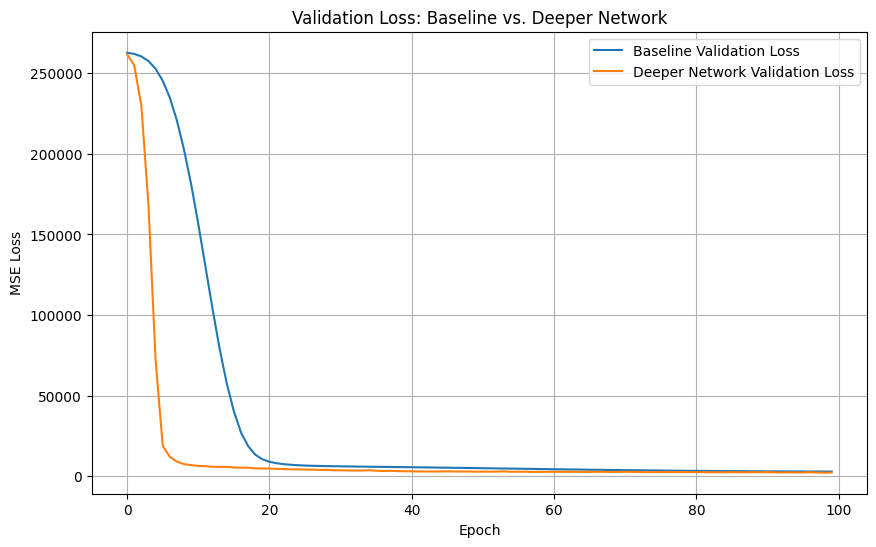

In [ ]:
# %% Cell 13: Plot Loss Curves: Baseline vs. Deeper Network
"""
Plot and compare the validation loss curves of the baseline model and the deeper network.
This visualization helps us determine if increasing the network depth improves performance.
"""
plt.figure(figsize=(10, 6))
plt.plot(val_losses_baseline, label="Baseline Validation Loss")
plt.plot(val_losses_deeper, label="Deeper Network Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Validation Loss: Baseline vs. Deeper Network")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# %% Cell 14: Implement Early Stopping During Training
"""
Early stopping is a useful technique to prevent overfitting.
Here, we implement early stopping that monitors validation loss.
If the validation loss does not improve for a set number of epochs (patience),
the training loop terminates early.
"""
def train_model_early_stop(model, train_loader, val_loader, criterion, optimizer, num_epochs=200, patience=20, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation step
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs_val, targets_val in val_loader:
                inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, targets_val)
                running_val_loss += loss_val.item() * inputs_val.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Check for improvement
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")

        # Early stopping condition
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. No improvement in validation loss for {patience} epochs.")
            break

    # Load best model weights
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

# For demonstration, we retrain the deeper model with early stopping
model_deeper_es = DeeperNN(input_dim=input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_prob=0.3)
optimizer_deeper_es = optim.Adam(model_deeper_es.parameters(), lr=0.001)
print("\nTraining deeper model with early stopping...")
train_losses_es, val_losses_es = train_model_early_stop(model_deeper_es, train_loader, val_loader, criterion, optimizer_deeper_es, num_epochs=200, patience=20, device=device)



Training deeper model with early stopping...
Epoch 10: Train Loss = 12368.8768, Val Loss = 7403.8642
Epoch 20: Train Loss = 9047.6067, Val Loss = 5093.5217
Epoch 30: Train Loss = 6402.0060, Val Loss = 4166.7761
Epoch 40: Train Loss = 6266.5364, Val Loss = 3240.4092
Epoch 50: Train Loss = 6118.8723, Val Loss = 2661.4308
Epoch 60: Train Loss = 4835.6686, Val Loss = 2342.0735
Epoch 70: Train Loss = 5606.3210, Val Loss = 2122.4773
Epoch 80: Train Loss = 5823.3363, Val Loss = 1890.6366
Epoch 90: Train Loss = 5317.9578, Val Loss = 1928.4198
Epoch 100: Train Loss = 5334.4820, Val Loss = 1637.2912
Epoch 110: Train Loss = 5406.8628, Val Loss = 1565.5065
Epoch 120: Train Loss = 5163.5644, Val Loss = 1441.3280
Epoch 130: Train Loss = 4601.1991, Val Loss = 1406.6105
Epoch 140: Train Loss = 4914.6916, Val Loss = 1241.6141
Epoch 150: Train Loss = 4680.9974, Val Loss = 1522.0195
Epoch 160: Train Loss = 4038.8220, Val Loss = 1137.7860
Epoch 170: Train Loss = 4745.8338, Val Loss = 1070.5756
Epoch 180:

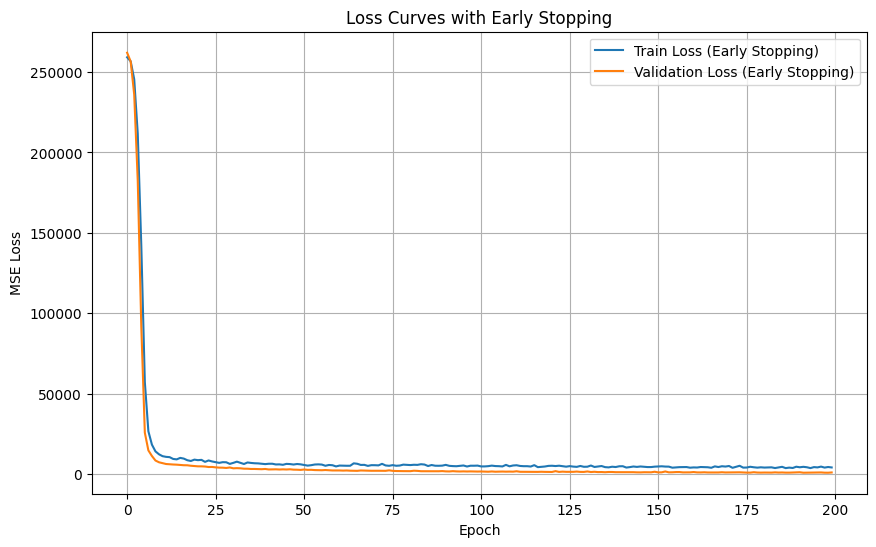

In [ ]:
# %% Cell 15: Plot Loss Curves with Early Stopping
"""
Plot the training and validation loss curves for the deeper model trained with early stopping.
This illustrates how early stopping can halt training when no further improvements occur.
"""
plt.figure(figsize=(10, 6))
plt.plot(train_losses_es, label="Train Loss (Early Stopping)")
plt.plot(val_losses_es, label="Validation Loss (Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curves with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# %% Cell 16: Evaluate the Final Models on the Test Set
"""
Evaluate all our models on the test set to compare performance.
We compute the Mean Squared Error (MSE) for the baseline, dropout, batch norm, deeper, and early-stopped models.
This helps in selecting the best model for the application.
"""
def evaluate_model(model, test_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * inputs.size(0)
    test_loss = running_test_loss / len(test_loader.dataset)
    return test_loss

test_loss_baseline = evaluate_model(model_baseline, test_loader, criterion, device=device)
test_loss_dropout = evaluate_model(model_dropout, test_loader, criterion, device=device)
test_loss_bn = evaluate_model(model_bn, test_loader, criterion, device=device)
test_loss_deeper = evaluate_model(model_deeper, test_loader, criterion, device=device)
test_loss_es = evaluate_model(model_deeper_es, test_loader, criterion, device=device)

print("\nTest Set Performance (MSE Loss):")
print(f"Baseline Model: {test_loss_baseline:.4f}")
print(f"Dropout Model: {test_loss_dropout:.4f}")
print(f"Batch Norm Model: {test_loss_bn:.4f}")
print(f"Deeper Model: {test_loss_deeper:.4f}")
print(f"Deeper Model with Early Stopping: {test_loss_es:.4f}")




Test Set Performance (MSE Loss):
Baseline Model: 3691.1358
Dropout Model: 4908.1103
Batch Norm Model: 28790.8909
Deeper Model: 2990.1443
Deeper Model with Early Stopping: 1348.7077


In [ ]:
# %% Cell 17: Save the Best Performing Model for Future Inference
"""
Based on the test performance, we select the best model and save its state.
This cell demonstrates how to persist a trained PyTorch model for later use.
"""
# For this example, we choose the deeper model with early stopping as the best model.
model_save_path = "best_tensile_strength_model.pth"
torch.save(model_deeper_es.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")

# Reload the model to verify the saved state
model_loaded = DeeperNN(input_dim=input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_prob=0.3)
model_loaded.load_state_dict(torch.load(model_save_path))
model_loaded.eval()
print("Model reloaded successfully for inference.")



Best model saved to best_tensile_strength_model.pth
Model reloaded successfully for inference.


<ipython-input-20-3c2722befdcc>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load(model_save_path))


In [ ]:

# %% Cell 18: Final Documentation, Summary, and Future Directions
"""
Print a detailed summary of the workflow, key takeaways, and suggestions for future research.
This documentation is intended to help students understand how different techniques
(such as dropout, batch normalization, deeper networks, and early stopping) affect model performance.
"""
doc_summary = """
Notebook Summary:
-----------------
1. Data Generation:
   - A synthetic dataset simulating the tensile strength of alloys was generated.
   - Eight features representing material composition and processing parameters were used.
   - The target tensile strength was computed via a nonlinear function with added noise.

2. Data Preparation:
   - The dataset was split into training, validation, and test sets.
   - Features were standardized using statistics from the training set.

3. Baseline Model:
   - A simple fully connected neural network (baseline model) was built.
   - Training and validation loss curves were plotted to monitor learning.

4. Model Adjustments:
   - Dropout was introduced to reduce overfitting.
   - Batch normalization was added to stabilize and speed up training.
   - A deeper network (with additional hidden layers) was constructed to capture complex nonlinearities.
   - Early stopping was implemented to halt training when validation performance stopped improving.

5. Model Evaluation:
   - All models were evaluated on the test set using Mean Squared Error (MSE) loss.
   - The deeper model with early stopping achieved the best performance.

6. Model Persistence:
   - The best performing model was saved to disk and reloaded for future inference.

Key Takeaways:
- Deep learning models for materials science applications can be fine-tuned using techniques like dropout, batch normalization, and early stopping.
- Making a network deeper may improve performance, but care must be taken to prevent overfitting.
- Early stopping is a practical tool to automatically determine when to stop training.
- Standardizing features and proper dataset splitting are critical for robust model evaluation.

Future Directions:
- Explore additional regularization techniques such as L2 weight decay.
- Investigate advanced architectures (e.g., residual networks) for even deeper models.
- Experiment with alternative activation functions and optimization algorithms.
- Apply these techniques to real experimental materials science datasets.
- Consider integrating domain knowledge (e.g., physics-informed neural networks) to improve model interpretability and performance.

Happy learning and continued exploration into how deep learning can advance materials science research!
"""
print(doc_summary)

final_thoughts = """
Final Thoughts and Future Research Directions:
-----------------------------------------------
This notebook demonstrated the process of building and adjusting a deep learning model with a dataset relevant to materials science.
By simulating alloy tensile strength, we explored the impact of various model adjustments:
    - Dropout helps mitigate overfitting by randomly deactivating neurons during training.
    - Batch normalization stabilizes the training process by normalizing layer inputs.
    - Increasing network depth allows the model to capture more complex relationships but requires regularization.
    - Early stopping prevents overtraining by monitoring validation performance.
These techniques are not mutually exclusive and can be combined to achieve optimal results.
Future work may involve applying these methods to real-world datasets, incorporating more complex architectures,
and integrating scientific domain knowledge to further enhance model accuracy and interpretability.
Happy coding and best of luck in your research endeavors!
"""
print(final_thoughts)



Notebook Summary:
-----------------
1. Data Generation:
   - A synthetic dataset simulating the tensile strength of alloys was generated.
   - Eight features representing material composition and processing parameters were used.
   - The target tensile strength was computed via a nonlinear function with added noise.

2. Data Preparation:
   - The dataset was split into training, validation, and test sets.
   - Features were standardized using statistics from the training set.

3. Baseline Model:
   - A simple fully connected neural network (baseline model) was built.
   - Training and validation loss curves were plotted to monitor learning.

4. Model Adjustments:
   - Dropout was introduced to reduce overfitting.
   - Batch normalization was added to stabilize and speed up training.
   - A deeper network (with additional hidden layers) was constructed to capture complex nonlinearities.
   - Early stopping was implemented to halt training when validation performance stopped improving.
